In [1]:
import xarray as xr 
import numpy as np
import pandas as pd
import re
import numpy.matlib as npm
from matplotlib import colors
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy import optimize
import json
import random as rd

In [2]:
def read_mgrid(filename,*args):
    """
    Función que toma la salida de *.nc de VMEC y genera un archivo de coordenadas que tiene el ángulo toroidal como coordenada
    principal.
    """
    file = xr.open_dataset(filename)

    nr = int(file.ir)
    nz = int(file.jz)
    nphi = int(file.kp)
    nfp = int(file.nfp)

    nextcur = int(file.nextcur)
    rmin = file.rmin
    rmax = file.rmax
    zmin = file.zmin
    zmax = file.zmax
    curlabel = file.coil_group
    

    br = np.zeros(shape=(nr,nz,nphi,nextcur))
    bphi= np.zeros(shape=(nr,nz,nphi,nextcur))
    bz = np.zeros(shape=(nr,nz,nphi,nextcur))
    bx = np.zeros(shape=(nr,nz,nphi,nextcur))
    by = np.zeros(shape=(nr,nz,nphi,nextcur))

    for i in range(0,nextcur):
        br[:,:,:,i] = np.array(file['br_%03d' % (i+1)]).T
        bphi[:,:,:,i] = np.array(file['bp_%03d' % (i+1)]).T
        bz[:,:,:,i] = np.array(file['bz_%03d' % (i+1)]).T
    
    phi = np.arange(start = 0, stop = 2*np.pi/nfp, step = 2*np.pi/(nfp*nphi))    
    raxis = np.linspace(rmin, rmax, num = nr, endpoint = True)
    zaxis = np.linspace(zmin, zmax, num = nz, endpoint = True)

    for k in range(1,nphi):
        bx[:,:,k,:] = np.multiply(br[:,:,k,:],np.cos(phi[k]))-np.multiply(bphi[:,:,k,:],np.sin(phi[k]))
        by[:,:,k,:] = -np.multiply(br[:,:,k,:],np.sin(phi[k]))+np.multiply(bphi[:,:,k,:],np.cos(phi[k]))

    ds = xr.Dataset({
        'br': xr.DataArray(
                data = br, 
                dims = ['nr','nz','nphi','nextcur'],
            ),
        'bphi': xr.DataArray(
                data = bphi, 
                dims = ['nr','nz','nphi','nextcur'],
            ),

        'bx': xr.DataArray(
                data = bx, 
                dims = ['nr','nz','nphi','nextcur'],
            ),
        
        'by': xr.DataArray(
                data = by, 
                dims = ['nr','nz','nphi','nextcur'],
            ),

        'bz': xr.DataArray(
                data = bz, 
                dims = ['nr','nz','nphi','nextcur'],
            ),

        'nfp':nfp, 

        'raxis': xr.DataArray(
                data = raxis,
                dims = ['R']
        ),

        'zaxis': xr.DataArray(
                data = zaxis,
                dims = ['Z']
        ),

        'phi': xr.DataArray(
                data = phi,
                dims = ['phi']
        ),

        'rmin':rmin, 
        'rmax':rmax, 
        'zmin':zmin,
        'zmax':zmax,

        'curlabel': xr.DataArray(
            data = curlabel
            )
    })

    return ds

In [3]:
# se realiza la lectura del archivo *.nc
data=read_mgrid('mgrid_MEDUSACR2.nc')

In [4]:
# se realiza la lectura del archivo de coordenadas de la superficie magnética en el corte 0 radianes
medusa_coords=np.loadtxt("coordenadasMEDUSA.txt",delimiter="\t")

In [5]:
# se crea la variable de la corriente
extcur=5.00000000000000E+03*np.ones(8)

In [6]:
# se genera la variable de campo magnético toroidal
bphi = np.zeros(data.bphi.shape)
for i in range(data.dims['nextcur']):
    bphi[:,:,:,i] = np.multiply(data.bphi[:,:,:,i],extcur[i]) # multiplica por la corriente externa
bphit = np.sum(bphi,axis = 3)

In [7]:
# se genera un mallado con los datos de R y z del archivo de coordenadas
Rx,zy=np.meshgrid(data.raxis,data.zaxis)

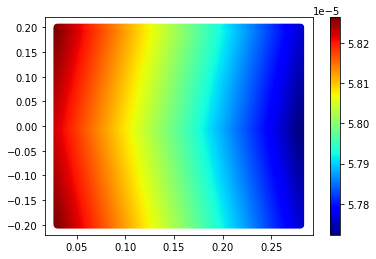

In [8]:
# se grafica la salida de VMEC
plt.scatter(Rx,zy,c=bphit[:,:,0].T,cmap='jet')
plt.colorbar()
plt.scatter(medusa_coords[:,0],medusa_coords[:,1])

# Extrapolación

## Muestreo Aleatorio

In [9]:
# se muestrea de forma aleatoria en los datos del mallado para generar tres arreglos unidimensionales que puedan servir de entrada para curve_fit
R_sample=[]
z_sample=[]
Bphi_sample=[]
for iPunto in range(1000):
    np.random.seed(np.random.randint(10**4,10**8))
    i=np.random.randint(0,len(data.raxis))
    j=np.random.randint(0,len(data.raxis))
    R_sample.append(Rx[i,j])
    z_sample.append(zy[i,j])
    Bphi_sample.append(bphit[:,:,0].T[i,j])

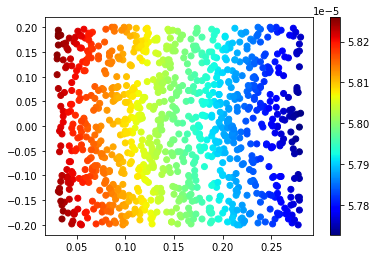

In [10]:
plt.scatter(R_sample,z_sample,c=Bphi_sample,cmap='jet')
plt.colorbar()

In [11]:
from scipy import optimize

In [12]:
def B_q(X,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O):
    '''
    Función que calcula el valor de una respuesta a partir de un modelo lineal genera con interacciones de orden 3.
    
    Parámetros de entrada:
    ----------------------
    X: Una tupla que contiene dos arreglos que con los valores de las variables independientes.
    A,B,C,D,E,F,G,H,I,J: Son los coeficientes de peso de la interacción.
    
    Salida:
    ----------------------
    Un arreglo con los valores de la función para los dos arreglos brindados en X.
    '''
    return (A*X[0]**4+B*X[1]**4+C*X[0]**3*X[1]+D*X[0]**2*X[1]**2+E*X[0]*X[1]**3+F*X[0]**3+G*X[1]**3+H*X[0]**2*X[1]+I*X[0]*X[1]**2+J*X[0]**2+K*X[1]**2+L*X[0]*X[1]+M*X[0]+N*X[1]+O)

In [13]:
# se realiza mínimos cuadrados para el modelo seleccionado y se obtienen los 15 coeficientes del modelo y la covarianza de estos
CoefsPhi,CovPhi=optimize.curve_fit(B_q,(R_sample,z_sample),Bphi_sample)

## Estimación del Campo Magnético como función de R y z

In [14]:
def ComponentesCampo(X,Coefs):
    """
    Función que toma los datos de una tupla X y un arreglo de 15 coeficientes para calcular el valor de la función de grado 4 con interacciones de cuarto orden.
    
    Parámetros de entrada:
    ----------------------
    X: tupla que posee los valores para R y z (R,z). R y z pueden tener forma matricial o de arreglo unidimensional o un valor solamente.
    Coefs: arreglo de 15 coeficientes.
    
    Salida:
    ----------------------
    Bq: el valor de la función, según la entrada puede ser una matriz, o un arreglo unidimensional o un valor.
    """
    # Se extraen los coeficientes
    A=Coefs[0]
    B=Coefs[1]
    C=Coefs[2]
    D=Coefs[3]
    E=Coefs[4]
    F=Coefs[5]
    G=Coefs[6]
    H=Coefs[7]
    I=Coefs[8]
    J=Coefs[9]
    K=Coefs[10]
    L=Coefs[11]
    M=Coefs[12]
    N=Coefs[13]
    O=Coefs[14]
    # Se calcula Bq
    Bq=A*X[0]**4+B*X[1]**4+C*X[0]**3*X[1]+D*X[0]**2*X[1]**2+E*X[0]*X[1]**3+F*X[0]**3+G*X[1]**3+H*X[0]**2*X[1]+I*X[0]*X[1]**2+J*X[0]**2+K*X[1]**2+L*X[0]*X[1]+M*X[0]+N*X[1]+O
    # Se grafica el resultado
    plt.scatter(X[0],X[1],c=Bq,cmap='jet')
    plt.xlabel('R [m]')
    plt.ylabel('z [m]')
    plt.colorbar()
    plt.show()
    return Bq

In [15]:
# Se crea un mallado que permita realizar la extrapolación utilizando la parametrización
z_prueba=np.arange(-0.2,0.2+0.0004,0.004)
R_prueba=np.arange(0,0.30+0.0003,0.003)
Rx_prueba,zy_prueba=np.meshgrid(R_prueba,z_prueba)

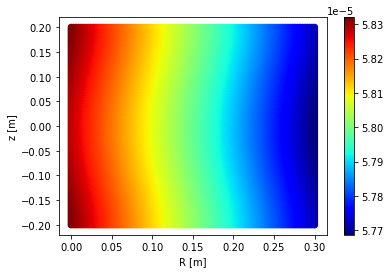

In [16]:
# Se calcula el valor de campo para el nuevo mallado de prueba
Bphi_calculado=ComponentesCampo((Rx_prueba,zy_prueba),CoefsPhi)

## Extrapolación

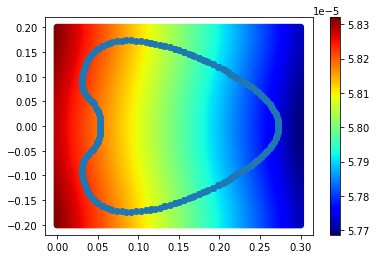

In [17]:
# Se grafica la superficie y la parametrización
plt.scatter(Rx_prueba,zy_prueba,c=Bphi_calculado,cmap='jet')
plt.colorbar()
plt.scatter(medusa_coords[:,0],medusa_coords[:,1])

# Estimación de la Superficie Transversal por Monte Carlo

In [18]:
# Se toman las coordenadas de medusa para calcular los valores de las componentes polares
medusa_r=np.sqrt(medusa_coords[:,0]**2+medusa_coords[:,1]**2)
medusa_theta=np.arctan(medusa_coords[:,1]/medusa_coords[:,0])
# Se separan según valores de theta negativos y positivos
medusa_polar_pos=[]
medusa_polar_neg=[]
for j in range(len(medusa_theta)):
    if medusa_theta[j]>=0:
        medusa_polar_pos.append([medusa_r[j],medusa_theta[j]])
    else:
        medusa_polar_neg.append([medusa_r[j],medusa_theta[j]])
# Se convierten en un arreglo de numpy
medusa_polar_pos=np.array(medusa_polar_pos)
medusa_polar_neg=np.array(medusa_polar_neg)
# Se hace un fit polinómico a las coordenadas polares, para escribir theta como función de r
p_pos=np.polyfit(medusa_polar_pos[:,0],medusa_polar_pos[:,1],(len(medusa_polar_pos[:,1]-1)))
p_neg=np.polyfit(medusa_polar_neg[:,0],medusa_polar_neg[:,1],(len(medusa_polar_neg[:,1]-1)))

C:\Users\Dell\anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Dell\anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
def MonteCarloÁrea(nTiros):
    """
    Función que calcula el área encerrada por una superficie de contorno utilizando el método de Monte Carlo con dos criterios de aceptación,
    el polar y el cartesiano.
    
    Parámetros de entrada:
    ----------------------
    nTiros: cantidad de datos aleatorios para R y z que se van a generar, estos pueden ser aceptados o no.
    
    Salida:
    ----------------------
    A: estimación del área encerrada por la superficie de contorno.
    """
    nAciertos=0
    contador=0
    At=(np.max(Rx)-np.min(Rx))*(np.max(zy)-np.min(zy))
    while contador<=nTiros:
        rd.seed()
        # Se generan R y z aleatorios que estén dentro de los límites del mallado
        R=rd.uniform(np.min(Rx),np.max(Rx))
        z=rd.uniform(np.min(zy),np.max(zy))
        # Se calculan los valores de r y theta polares
        r=np.sqrt(R**2+z**2)
        theta=np.arctan(z/R)
        # Se analiza si theta y r cumplen los criterios
        if theta<0 and np.min(medusa_r)<=r<=np.max(medusa_r):
            theta_eval=np.polyval(p_neg,r)
            if theta_eval<theta:
                nAciertos+=1
            else:
                pass
        else:
            theta_eval=np.polyval(p_pos,r)
            if theta_eval>theta and np.min(medusa_r)<=r<=np.max(medusa_r):
                nAciertos+=1
            else:
                pass
        contador+=1
    # Se calcula el área a partir del número de tiros, el de aciertos y el área total
    A=nAciertos*At/nTiros
    return A

In [20]:
AT=MonteCarloÁrea(1000)
AT

0.0611

# Estimación del Flujo Magnético

In [21]:
def Coord_Polares_Centradas_Curva(x,y):
    x_0 = np.sum(x)/len(x)
    y_0 = np.sum(y)/len(y)
    x_centradas = x-x_0
    y_centradas = y-y_0
    r = np.sqrt(x_centradas**2 + y_centradas**2)
    theta = np.arctan2(y_centradas,x_centradas)
    polares = np.column_stack([r,theta])
    return polares

In [22]:
def Coord_Polares_Centradas_Grid_Matrix(R,z,B,x_c,y_c):
    x_0 = np.sum(x_c)/len(x_c)
    y_0 = np.sum(y_c)/len(y_c)
    R_centradas = R-x_0
    z_centradas = z-y_0
    r = np.sqrt(R_centradas**2 + z_centradas**2)
    theta = np.arctan2(z_centradas,R_centradas)
    matrix_data = []
    for i in range(len(r)):
        matrix_data.append(np.column_stack((r[i],theta[i],B[i])))
    matrix_data = np.array(matrix_data)
    return matrix_data

In [28]:
def Flujo(angulo_tol):
    R = Rx
    z = zy
    B = bphit[:,:,0].T
    #Datos Meduso
    x, y = medusa_coords[:,0],medusa_coords[:,1]
    #Centrar Datos Polares
    polaresCurva = Coord_Polares_Centradas_Curva(x,y) 
    polaresGrid = Coord_Polares_Centradas_Grid_Matrix(R,z,B,x,y)
    #Eliminación de datos
    puntos = []
    dtheta = angulo_tol*(np.pi/180)
    for i in range(len(polaresCurva)):
        lim_sup = polaresCurva[i,1] + dtheta
        lim_inf = polaresCurva[i,1] - dtheta
        for j in range(len(polaresGrid)):
            for k in range(len(polaresGrid[j])):
                if  lim_inf < polaresGrid[j][k,1] <lim_sup and polaresGrid[j][k,0] < polaresCurva[i,0]:
                    puntos.append(polaresGrid[j][k])
    puntos = np.array(puntos)
    #Cálculo del flujo
    dA = AT/len(puntos)
    flujo = puntos[:,2]*dA
    flujo_total =np.sum(flujo)
    return flujo_total, puntos,polaresCurva

In [29]:
flujo, puntos, curva =Flujo(2)
flujo

3.5459659094553767e-06

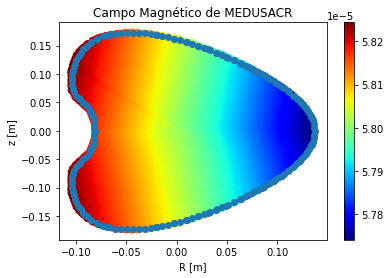

Flujo: 3.5459659094553767e-06


In [30]:
plt.scatter(puntos[:,0]*np.cos(puntos[:,1]),puntos[:,0]*np.sin(puntos[:,1]),c=puntos[:,2],cmap="jet")
plt.colorbar()
plt.scatter(curva[:,0]*np.cos(curva[:,1]),curva[:,0]*np.sin(curva[:,1]))
plt.xlabel("R [m]")
plt.ylabel("z [m]")
plt.title("Campo Magnético de MEDUSACR")
plt.show()
print("Flujo:",flujo)